Задача определения положения головы.
Подход к решению был заимствован их статьи Head pose Estimation Using Convolutional Neural Networks Xingyu Liu June 6, 2016
В частности была воспроизведена архитектура нейросети, предложенная в статье и лосс функция.
Обучение проводилось на датасетах
http://www-prima.inrialpes.fr/perso/Gourier/Faces/HPDatabase.html
https://areeweb.polito.it/ricerca/cgvg/siblingsDB.html

In [1]:
from mtcnn.mtcnn import MTCNN
import pickle
import numpy as np 
import matplotlib.pyplot as plt
from imutils import paths
import os
import PIL
from scipy.spatial.distance import cosine 
%matplotlib inline
import keras
import cv2
from tqdm import tqdm
from keras.models import load_model
import numpy as np
import keras.backend as K
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D,ZeroPadding2D
from keras import regularizers
from keras.utils import np_utils
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras.callbacks import ModelCheckpoint
from six.moves import cPickle as pickle
from keras.utils.np_utils import to_categorical
import keras.backend as K
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D,ZeroPadding2D
from keras import regularizers
from keras.utils import np_utils
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical

from keras.layers import Input, Dense, Add, Activation
from keras.models import Model

       
from keras.layers import Input, Dense, Add, Activation, BatchNormalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,Conv1D, MaxPooling2D
import glob
from scipy.spatial.distance import euclidean
import re

mtcnn_detector = MTCNN()

/home/aevdakimov/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aevdakimov/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aevdakimov/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aevdakimov/anaconda3/envs/myenv

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices())

['/device:CPU:0', '/device:GPU:0', '/device:GPU:1']


In [4]:
# Поскольку положение головы определяется двумя углами, то можно использовать в качестве функции потерь
# увклидово расстояние межде предиктом и groudtruth значениями

def euclidean_distance_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [ ]:
# создадим датасет
# Разметка зашита в названии файла. Ее можно распарсить через регулярки

In [ ]:
# Первая координата-вертикальный угол
# Вторая -горизонтальный

In [393]:
paths = glob.glob('/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/*/*.jpg')

X = []
Y = []

for path in paths:
    try:
        print(path)
        rgb = cv2.imread(path)
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB) 
        box = mtcnn_detector.detect_faces(rgb)[0]['box']
        rgb_cropped = rgb[box[1]:box[1]+max(box[3],box[2]),box[0]:box[0]+max(box[2],box[3])]
        
        rgb_cropped = PIL.Image.fromarray(rgb_cropped)
        rgb_cropped = rgb_cropped.resize((128,128))
        rgb_cropped = np.array(rgb_cropped)
        rgb_cropped = rgb_cropped/255.
        
        X.append(rgb_cropped)
        
        
        Y.append([(float(re.findall(r'[+0,0,-0,+15,-15,+30,-30,+45,-45,+60,-60,+75,-75,+90,-90]\w+', path[78:-4])[0]),
                       float(re.findall(r'[+0,0,-0,+15,-15,+30,-30,+45,-45,+60,-60,+75,-75,+90,-90]\w+', path[78:-4])[1]))])
        
                
    except Exception as e:
        print(e)
        
X_train = np.array(X)
Y_train = np.reshape(np.array(Y), (len(Y),2))

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02206-60-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02267+30-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02243+0-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02212-60+75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02272+30+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02161+15+30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02129-15-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02167+30-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02248+0+30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02207-60+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02171+30-15.jpg
/media/aevdakimov/HDisk/A

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02218-30-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02140+0-90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02184+60-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02174+30+30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02280+60-75.jpg
tile cannot extend outside image
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02253+15-90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02240+0-90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02115-30-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02145+0-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02104-60-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02288+6

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02209-60+30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person02/person02142+0-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/new_front/1561035061757.jpg
list index out of range
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/new_front/1561032699343.jpg
tile cannot extend outside image
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/new_front/1563277360961.jpg
list index out of range
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/new_front/1561033671197.jpg
list index out of range
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/new_front/1561033072419.jpg
list index out of range
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/new_front/1561032429418.jpg
list index out of range
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/new_front/1561033028138.jpg
list index out of range
/media/aevdakimov/HDisk/Arthur/HeadPose/Head

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person11/person11286+60+15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person11/person11106-60-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person11/person11116-30-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person11/person11182+60-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person11/person11149+0+45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person11/person11159+15+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person11/person11132-15-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person11/person11164+15+75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person11/person11150+0+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person11/person11225-30+75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person11/person11254+15-75.jpg
/media/aevdakimov/HDisk/

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person11/person11137-15+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person11/person11192+90+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person11/person11208-60+15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person11/person11189+60+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person11/person11227-15-90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person11/person11125-30+75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person11/person11204-60-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person11/person11283+60-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person11/person11209-60+30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person11/person11229-15-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person11/person11202-60-75.jpg
/media/aevdakimov/HDis

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person08/person08105-60-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person08/person08123-30+45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person08/person08126-30+90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person08/person08144+0-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person08/person08233-15+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person08/person08283+60-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person08/person08103-60-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person08/person08147+0+15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person08/person08237-15+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person08/person08256+15-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person08/person08262+15+45.jpg
/media/aevdakimov/HDisk/

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person08/person08184+60-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person08/person08276+30+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person08/person08254+15-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person08/person08115-30-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person08/person08187+60+30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person08/person08139-15+90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person08/person08104-60-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person08/person08191+60+90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person08/person08219-30-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person08/person08290+60+75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person08/person08145+0-15.jpg
/media/aevdakimov/HDis

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person05/person05270+30-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person05/person05178+30+90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person05/person05149+0+45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person05/person05254+15-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person05/person05105-60-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person05/person05240+0-90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person05/person05236-15+45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person05/person05124-30+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person05/person05152+0+90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person05/person05170+30-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person05/person05220-30+0.jpg
/media/aevdakimov/HDisk/A

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person05/person05171+30-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person05/person05243+0-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person05/person05239-15+90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person05/person05182+60-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person05/person05216-30-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person05/person05201-60-90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person05/person05247+0+15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person05/person05145+0-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person05/person05241+0-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person05/person05290+60+75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person05/person05177+30+75.jpg
/media/aevdakimov/HDisk/A

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person09/person09160+15+15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person09/person09274+30+30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person09/person09107-60+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person09/person09251+0+75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person09/person09100-90+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person09/person09277+30+75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person09/person09281+60-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person09/person09180+60-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person09/person09252+0+90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person09/person09204-60-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person09/person09272+30+0.jpg
/media/aevdakimov/HDisk/Ar

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person09/person09289+60+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person09/person09268+30-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person09/person09182+60-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person09/person09246+0+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person09/person09187+60+30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person09/person09142+0-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person09/person09226-30+90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person09/person09141+0-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person09/person09273+30+15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person09/person09128-15-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person09/person09261+15+30.jpg
/media/aevdakimov/HDisk/A

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person06/person06165+15+90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person06/person06268+30-60.jpg
tile cannot extend outside image
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person06/person06143+0-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person06/person06129-15-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person06/person06141+0-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person06/person06272+30+0.jpg
tile cannot extend outside image
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person06/person06168+30-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person06/person06180+60-75.jpg
tile cannot extend outside image
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person06/person06109-60+30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person06/person06124-30+60.jpg
/media/aevdaki

tile cannot extend outside image
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person06/person06218-30-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person06/person06208-60+15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person06/person06210-60+45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person06/person06190+60+75.jpg
tile cannot extend outside image
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person06/person06211-60+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person06/person06248+0+30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person06/person06145+0-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person06/person06107-60+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person06/person06226-30+90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person06/person06123-30+45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_po

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person15/person15242+0-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person15/person15154+15-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person15/person15180+60-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person15/person15118-30-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person15/person15215-30-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person15/person15231-15-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person15/person15163+15+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person15/person15221-30+15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person15/person15172+30+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person15/person15234-15+15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person15/person15281+60-60.jpg
/media/aevdakimov/HDisk

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person15/person15137-15+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person15/person15284+60-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person15/person15245+0-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person15/person15289+60+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person15/person15243+0-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person15/person15179+60-90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person15/person15200-90+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person15/person15203-60-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person15/person15248+0+30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person15/person15262+15+45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person15/person15174+30+30.jpg
/media/aevdakimov/HDisk/A

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person03/person03184+60-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person03/person03213-60+90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person03/person03122-30+30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person03/person03157+15-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person03/person03165+15+90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person03/person03280+60-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person03/person03268+30-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person03/person03131-15-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person03/person03144+0-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person03/person03273+30+15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person03/person03123-30+45.jpg
/media/aevdakimov/HDis

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person03/person03137-15+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person03/person03142+0-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person03/person03183+60-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person03/person03166+30-90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person03/person03252+0+90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person03/person03181+60-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person03/person03167+30-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person03/person03107-60+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person03/person03236-15+45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person03/person03159+15+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person03/person03264+15+75.jpg
/media/aevdakimov/HDisk/A

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person04/person04218-30-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person04/person04156+15-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person04/person04133-15+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person04/person04142+0-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person04/person04220-30+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person04/person04137-15+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person04/person04232-15-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person04/person04178+30+90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person04/person04256+15-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person04/person04274+30+30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person04/person04239-15+90.jpg
/media/aevdakimov/HDisk/

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person04/person04273+30+15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person04/person04217-30-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person04/person04224-30+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person04/person04251+0+75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person04/person04107-60+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person04/person04130-15-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person04/person04223-30+45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person04/person04252+0+90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person04/person04132-15-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person04/person04245+0-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person04/person04233-15+0.jpg
/media/aevdakimov/HDisk/Ar

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person14/person14203-60-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person14/person14165+15+90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person14/person14159+15+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person14/person14221-30+15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person14/person14285+60+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person14/person14250+0+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person14/person14224-30+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person14/person14110-60+45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person14/person14211-60+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person14/person14160+15+15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person14/person14288+60+45.jpg
/media/aevdakimov/HDisk/

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person14/person14220-30+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person14/person14256+15-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person14/person14152+0+90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person14/person14270+30-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person14/person14261+15+30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person14/person14275+30+45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person14/person14146+0+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person14/person14247+0+15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person14/person14255+15-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person14/person14236-15+45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person14/person14245+0-15.jpg
/media/aevdakimov/HDisk/Art

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person07/person07116-30-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person07/person07249+0+45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person07/person07130-15-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person07/person07132-15-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person07/person07152+0+90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person07/person07121-30+15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person07/person07185+60+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person07/person07257+15-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person07/person07230-15-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person07/person07183+60-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person07/person07165+15+90.jpg
/media/aevdakimov/HDisk/

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person07/person07261+15+30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person07/person07223-30+45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person07/person07206-60-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person07/person07184+60-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person07/person07162+15+45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person07/person07110-60+45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person07/person07289+60+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person07/person07260+15+15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person07/person07142+0-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person07/person07225-30+75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person07/person07143+0-45.jpg
/media/aevdakimov/HDisk

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person01/person01247+0+15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person01/person01130-15-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person01/person01171+30-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person01/person01264+15+75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person01/person01158+15-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person01/person01219-30-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person01/person01217-30-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person01/person01128-15-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person01/person01115-30-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person01/person01137-15+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person01/person01238-15+75.jpg
/media/aevdakimov/HDis

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person01/person01107-60+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person01/person01211-60+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person01/person01126-30+90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person01/person01181+60-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person01/person01150+0+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person01/person01110-60+45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person01/person01186+60+15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person01/person01105-60-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person01/person01172+30+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person01/person01129-15-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person01/person01256+15-45.jpg
/media/aevdakimov/HDisk/

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person13/person13182+60-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person13/person13239-15+90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person13/person13173+30+15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person13/person13215-30-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person13/person13289+60+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person13/person13250+0+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person13/person13231-15-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person13/person13244+0-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person13/person13123-30+45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person13/person13232-15-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person13/person13285+60+0.jpg
/media/aevdakimov/HDisk/

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person13/person13276+30+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person13/person13136-15+45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person13/person13281+60-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person13/person13170+30-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person13/person13134-15+15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person13/person13207-60+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person13/person13238-15+75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person13/person13257+15-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person13/person13158+15-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person13/person13216-30-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person13/person13139-15+90.jpg
/media/aevdakimov/HDis

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person10/person10213-60+90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person10/person10128-15-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person10/person10105-60-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person10/person10148+0+30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person10/person10279+60-90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person10/person10262+15+45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person10/person10185+60+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person10/person10226-30+90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person10/person10169+30-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person10/person10156+15-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person10/person10133-15+0.jpg
/media/aevdakimov/HDisk/

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person10/person10179+60-90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person10/person10134-15+15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person10/person10245+0-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person10/person10241+0-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person10/person10100-90+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person10/person10132-15-15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person10/person10202-60-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person10/person10155+15-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person10/person10159+15+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person10/person10209-60+30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person10/person10266+30-90.jpg
/media/aevdakimov/HDisk/A

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person12/person12124-30+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person12/person12211-60+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person12/person12253+15-90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person12/person12156+15-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person12/person12137-15+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person12/person12153+15-90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person12/person12241+0-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person12/person12181+60-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person12/person12150+0+60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person12/person12117-30-45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person12/person12221-30+15.jpg
/media/aevdakimov/HDisk

/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person12/person12164+15+75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person12/person12112-60+75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person12/person12183+60-30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person12/person12254+15-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person12/person12216-30-60.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person12/person12180+60-75.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person12/person12275+30+45.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person12/person12274+30+30.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person12/person12127-15-90.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person12/person12208-60+15.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Head_pose_dataset/Person12/person12228-15-75.jpg
/media/aevdakimov/HDi

In [210]:
# Сделаем небольшую аугментацию - флипанем горизонтально изображения и поменям знак в горизонтальной координате

In [375]:
X_train_flipped = np.flip(X_train, axis=2)
Y_train_flipped=[]
for i in Y_train:
    Y_train_flipped.append([i[0],i[1]*(-1)])
    
Y_train_flipped = np.array(Y_train_flipped)

In [376]:
#Добавим фронтальные положения
paths_front = glob.glob('/media/aevdakimov/HDisk/Arthur/HeadPose/Front/*.jpg') 

X_front = []
Y_front =[]

for path in paths_front:
    try:
        print(path)
        rgb = cv2.imread(path)
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB) 
        box = mtcnn_detector.detect_faces(rgb)[0]['box']
        rgb_cropped = rgb[box[1]:box[1]+max(box[3],box[2]),box[0]:box[0]+max(box[2],box[3])]
        
        rgb_cropped = PIL.Image.fromarray(rgb_cropped)
        rgb_cropped = rgb_cropped.resize((128,128))
        rgb_cropped = np.array(rgb_cropped)
        rgb_cropped = rgb_cropped/255.
        
        X_front.append(rgb_cropped)
        
        
        Y_front.append([(0,0)])
        
        
        
    except Exception as e:
        print(e)
        
X_front = np.array(X_front)
Y_front = np.reshape(np.array(Y_front), (len(Y_front),2))

/media/aevdakimov/HDisk/Arthur/HeadPose/Front/personne07146+0+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Front/personne07246+0+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Front/personne14246+0+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Front/personne06146+0+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Front/personne09146+0+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Front/personne08146+0+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Front/personne05246+0+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Front/personne15146+0+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Front/personne13146+0+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Front/personne06246+0+0.jpg
tile cannot extend outside image
/media/aevdakimov/HDisk/Arthur/HeadPose/Front/personne04246+0+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Front/personne12246+0+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Front/personne13246+0+0.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/Front/personne03146+0+0.jpg
/media/aevdakim

In [298]:
# стакаем

X = np.vstack((X_train,X_train_flipped,X_front))
Y = np.vstack((Y_train,Y_train_flipped,Y_front))

In [300]:
pickle_out = open("Xpickle_128_stacked_with_front", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()
pickle_out = open("ypickle_128_stacked_with_front", "wb")
pickle.dump(Y, pickle_out)
pickle_out.close()

In [5]:
X_train = np.load('/media/aevdakimov/HDisk/Arthur/HeadPose/Xpickle_128_stacked_with_front',allow_pickle=True)
Y_train = np.load('/media/aevdakimov/HDisk/Arthur/HeadPose/ypickle_128_stacked_with_front',allow_pickle=True)

In [302]:
## from keras.layers import Conv2D,Conv1D, MaxPooling2D
from keras.layers import Input, Dense, Add, Activation, GlobalAveragePooling2D
from keras.models import Model
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.33, shuffle=True)


RMSPROP = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
        


img_shape = 128
num_channels = 3

input_img = Input(shape=(img_shape, img_shape, num_channels))


X = input_img


X = Conv2D(64, (3,3), padding='same', activation='relu')(X)
X = Conv2D(64, (3,3), padding='same', activation='relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X) 



X = Conv2D(64, (3,3), padding='same', activation='relu')(X)
X = Conv2D(64, (3,3), padding='same', activation='relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X) 



X = Conv2D(128, (3,3), padding='same', activation='relu')(X)
X = Conv2D(128, (3,3), padding='same', activation='relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X) 



X = Conv2D(128, (3,3), padding='same', activation='relu')(X)
X = Conv2D(128, (3,3), padding='same', activation='relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X) 



X = Conv2D(256, (3,3), padding='same', activation='relu')(X)
X = Conv2D(256, (3,3), padding='same', activation='relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X)



X = Conv2D(256, (3,3), padding='same', activation='relu')(X)
X = Conv2D(256, (3,3), padding='same', activation='relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X)



X = Conv2D(256, (3,3), padding='same', activation='relu')(X)
X = Conv2D(256, (3,3), padding='same', activation='relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X)

X = Flatten()(X)                                                                      


X = Dense(1024, activation='relu')(X)
X = Dense(1024, activation='relu')(X)

predictions = Dense(2, activation='linear')(X)


model = Model(inputs=input_img, outputs=predictions)
model.compile(optimizer=RMSPROP,
              loss=euclidean_distance_loss,
             metrics=['mse'])

filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.fit(X_train, Y_train, validation_data=(X_test, Y_test) , batch_size=8, epochs=50,  callbacks=callbacks_list)
#model.summary()

Train on 3644 samples, validate on 1795 samples
Epoch 1/50
3644/3644 [==============================] - 14s 4ms/step - loss: 68.3773 - mean_squared_error: 10163.7654 - val_loss: 61.4685 - val_mean_squared_error: 2242.2888
Epoch 2/50
3644/3644 [==============================] - 13s 3ms/step - loss: 60.1545 - mean_squared_error: 3172.8931 - val_loss: 41.2578 - val_mean_squared_error: 1100.1099
Epoch 3/50
3644/3644 [==============================] - 13s 4ms/step - loss: 42.1055 - mean_squared_error: 1162.1440 - val_loss: 37.7134 - val_mean_squared_error: 858.1996
Epoch 4/50
3644/3644 [==============================] - 12s 3ms/step - loss: 30.5881 - mean_squared_error: 623.4750 - val_loss: 28.8277 - val_mean_squared_error: 529.3214
Epoch 5/50
3644/3644 [==============================] - 13s 3ms/step - loss: 24.8047 - mean_squared_error: 411.6684 - val_loss: 21.0412 - val_mean_squared_error: 296.9345
Epoch 6/50
3644/3644 [==============================] - 13s 3ms/step - loss: 22.2576 - mean

Epoch 49/50
3644/3644 [==============================] - 13s 3ms/step - loss: 5.8865 - mean_squared_error: 26.7022 - val_loss: 11.0419 - val_mean_squared_error: 89.1428
Epoch 50/50
3644/3644 [==============================] - 13s 3ms/step - loss: 5.8897 - mean_squared_error: 26.5961 - val_loss: 11.2485 - val_mean_squared_error: 95.5792


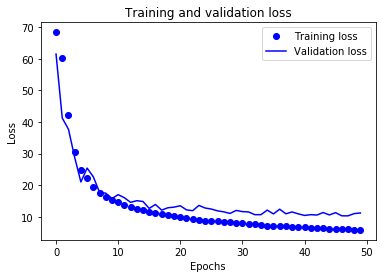

In [303]:
import matplotlib.pyplot as plt
history_dict = model.history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(50)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')

plt.ylabel('Loss')
plt.legend()
plt.show()

[[ -5.262172 -51.588223]]


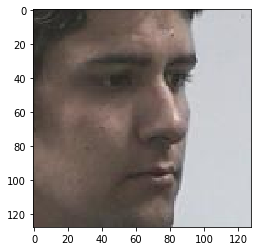

In [334]:
n = 40

print(model.predict(np.expand_dims(X_test[n], axis = 0)))
plt.imshow(X_test[n])

[[-28.328274  72.99346 ]]


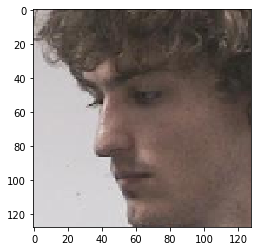

In [330]:
n = 0

print(model.predict(np.expand_dims(X_train[n], axis = 0)))
plt.imshow(X_train[n])

array([[-26.281504 ,  13.2384405]], dtype=float32)

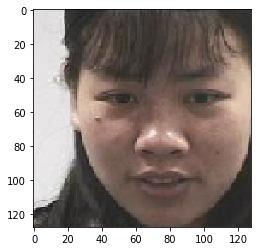

In [354]:
n= 20

plt.imshow(X_test[n])
model.predict(np.expand_dims(X_test[n], axis = 0))

In [ ]:
# Похоже, что модель относительно неплохо отрабатывает на углах поворота больше 15 градусов,
# но не справляется с фронтальными изображениям (действительно, в обучающей выборке подобных объектов было ~30)
# можно попробовать дообучить модель добавив фронтальные фотографии

In [356]:
#Добавим фронтальные положения (dataset Siblings)

paths_front = glob.glob('/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/*/*.jpg') 

X_front_sib = []
Y_front_sib =[]

for path in paths_front:
    try:
        print(path)
        rgb = cv2.imread(path)
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB) 
        box = mtcnn_detector.detect_faces(rgb)[0]['box']
        rgb_cropped = rgb[box[1]:box[1]+max(box[3],box[2]),box[0]:box[0]+max(box[2],box[3])]
        
        rgb_cropped = PIL.Image.fromarray(rgb_cropped)
        rgb_cropped = rgb_cropped.resize((128,128))
        rgb_cropped = np.array(rgb_cropped)
        rgb_cropped = rgb_cropped/255.
        
        X_front_sib.append(rgb_cropped)
        
        
        Y_front_sib.append([(0,0)])
        
        
        
    except Exception as e:
        print(e)
        
X_front_sib = np.array(X_front_sib)
Y_front_sib = np.reshape(np.array(Y_front_sib), (len(Y_front_sib),2))

/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/259/259.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/254/_DSC3036.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/7/_DSC5769.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/163/_DSC0633.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/41/_DSC5937.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/182/_DSC0720.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/90/_DSC0091.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/115/_DSC0266.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/91/_DSC0099.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/255/_DSC3048.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/151/_DSC0579.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/133/_DSC0401.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/247/_DSC2966.jpg
/media/ae

/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/184/_DSC0736.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/154/_DSC0598.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/250/_DSC3013.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/129/_DSC0369.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/201/_DSC0852.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/16/_DSC5850.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/97/_DSC0130.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/155/_DSC0609.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/150/_DSC0572.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/221/_DSC2256.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/202/_DSC0859.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/246/_DSC2982.jpg
/media/aevdakimov/HDisk/Arthur/HeadPose/siblings_DB/DBs/HQf/74/074.jpg
/media/

In [ ]:
X = np.vstack((X_train,X_front_sib))
Y = np.vstack((Y_train,Y_front_sib))

In [414]:
pickle_out = open("Xpickle_128_stacked_with_front_with_sibl", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()
pickle_out = open("ypickle_128_stacked_with_front_with_sibl", "wb")
pickle.dump(Y, pickle_out)
pickle_out.close()

In [381]:
# обучим

In [8]:
X_train = np.load('/media/aevdakimov/HDisk/Arthur/HeadPose/Xpickle_128_stacked_with_front_with_sibl',allow_pickle=True)
Y_train = np.load('/media/aevdakimov/HDisk/Arthur/HeadPose/ypickle_128_stacked_with_front_with_sibl',allow_pickle=True)

In [17]:
## from keras.layers import Conv2D,Conv1D, MaxPooling2D
from keras.layers import Input, Dense, Add, Activation, GlobalAveragePooling2D
from keras.models import Model
from sklearn.model_selection import train_test_split

X_train = np.load('/media/aevdakimov/HDisk/Arthur/HeadPose/Xpickle_128_stacked_with_front_with_sibl',allow_pickle=True)
Y_train = np.load('/media/aevdakimov/HDisk/Arthur/HeadPose/ypickle_128_stacked_with_front_with_sibl',allow_pickle=True)



X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.25, shuffle=True)


RMSPROP = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
        


img_shape = 128
num_channels = 3

input_img = Input(shape=(img_shape, img_shape, num_channels))


X = input_img


X = Conv2D(64, (3,3), padding='same', activation='relu')(X)
X = Conv2D(64, (3,3), padding='same', activation='relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X) 



X = Conv2D(64, (3,3), padding='same', activation='relu')(X)
X = Conv2D(64, (3,3), padding='same', activation='relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X) 



X = Conv2D(128, (3,3), padding='same', activation='relu')(X)
X = Conv2D(128, (3,3), padding='same', activation='relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X) 



X = Conv2D(128, (3,3), padding='same', activation='relu')(X)
X = Conv2D(128, (3,3), padding='same', activation='relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X) 



X = Conv2D(256, (3,3), padding='same', activation='relu')(X)
X = Conv2D(256, (3,3), padding='same', activation='relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X)



X = Conv2D(256, (3,3), padding='same', activation='relu')(X)
X = Conv2D(256, (3,3), padding='same', activation='relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X)



X = Conv2D(256, (3,3), padding='same', activation='relu')(X)
X = Conv2D(256, (3,3), padding='same', activation='relu')(X)
X = MaxPooling2D(pool_size=(2, 2))(X)

X = Flatten()(X)                                                                      


X = Dense(1024, activation='relu')(X)
X = Dense(1024, activation='relu')(X)

predictions = Dense(2, activation='linear')(X)


model = Model(inputs=input_img, outputs=predictions)
model.compile(optimizer=RMSPROP,
              loss=euclidean_distance_loss,
             metrics=['mse'])

filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}_sibl.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.fit(X_train, Y_train, validation_data=(X_test, Y_test) , batch_size=8, epochs=50,  callbacks=callbacks_list)
#model.summary()

Train on 4214 samples, validate on 1405 samples
Epoch 1/50
4214/4214 [==============================] - 14s 3ms/step - loss: 66.1697 - mean_squared_error: 4536.1753 - val_loss: 58.7497 - val_mean_squared_error: 2081.0602
Epoch 2/50
4214/4214 [==============================] - 13s 3ms/step - loss: 46.0988 - mean_squared_error: 1542.4956 - val_loss: 37.3151 - val_mean_squared_error: 870.8380
Epoch 3/50
4214/4214 [==============================] - 13s 3ms/step - loss: 29.8743 - mean_squared_error: 597.7319 - val_loss: 23.1919 - val_mean_squared_error: 357.8172
Epoch 4/50
4214/4214 [==============================] - 13s 3ms/step - loss: 23.0781 - mean_squared_error: 361.1490 - val_loss: 27.4206 - val_mean_squared_error: 492.7548
Epoch 5/50
4214/4214 [==============================] - 13s 3ms/step - loss: 20.4171 - mean_squared_error: 289.8374 - val_loss: 18.1545 - val_mean_squared_error: 230.4811
Epoch 6/50
4214/4214 [==============================] - 13s 3ms/step - loss: 18.0470 - mean_sq

Epoch 49/50
4214/4214 [==============================] - 13s 3ms/step - loss: 5.8126 - mean_squared_error: 28.4085 - val_loss: 8.8554 - val_mean_squared_error: 66.4553
Epoch 50/50
4214/4214 [==============================] - 13s 3ms/step - loss: 5.8697 - mean_squared_error: 28.9145 - val_loss: 9.3118 - val_mean_squared_error: 70.1948


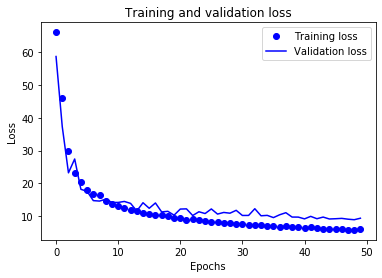

In [18]:
import matplotlib.pyplot as plt
history_dict = model.history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(50)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')

plt.ylabel('Loss')
plt.legend()
plt.show()

array([[-19.307089 ,  -0.4037153]], dtype=float32)

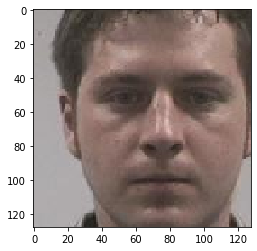

In [156]:
n= 100

plt.imshow(X_test[n])
model.predict(np.expand_dims(X_test[n], axis = 0))

array([[-57.77744, -67.58997]], dtype=float32)

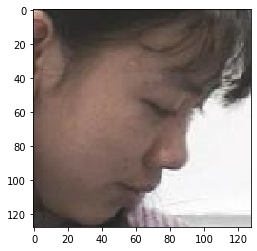

In [157]:
n= 200

plt.imshow(X_test[n])
model.predict(np.expand_dims(X_test[n], axis = 0))

In [ ]:
# Видно, что значение лосс функции уменьшилось, причем разница на трейне и валидации не сильно большая.
# Модель немного лучше различает малые углы,но подобных примеров для обучения всё еще не хватает